# Analysis Workflow

# Motivation
- Partial wave analysis can be complicated (fitting, bookkeeping, result handling, ...)
- PyAmpTools sacrifices flexibility for ease of use and focuses on Python as the core language
- **Features:**
    - Scientific Python ecosystem is massive (achieve most of the benefits of low level languages without the hassle)
    - Optimization uses gradients provided by JAX automatic differentiation (scales better than numerical diff.)
    - Hooks into several optimization frameworks spanning MLE, MCMC, to Variational Inference
        - iminuit, scipy, numpyro, iftpwa
    - YAML file is used to configure the analysis for consistency and automation
    - Fitting is generally done through the command line

# Example

This analysis chain is an example of an **input/output** study. 

1. We draw a sample from the nifty prior distribution
2. generate simulations (using `gen_amp` + `halld_sim/Piecewise` amplitude mimicking prior sample)
3. bin the data
4. fit the simulated data using:
    - Maximum Likelihood Estimation (MLE)
    - Markov Chain Monte Carlo (MCMC)
    - Information Field Theory (IFT)
5. plot the results

We would like to show a high probability of reconstruction. If this occurs for a wide variety of samples (and we believe our data could be approximately described by the very-flexible nifty prior) then we have successfully demonstrated that inference would be robust.

![alt text](optimization_mermaid.png)

In [13]:
import os
import subprocess
from pyamptools.utility.resultManager import ResultManager
from pyamptools.utility.resultManager import (
    plot_binned_intensities, 
    plot_binned_complex_plane, 
    plot_overview_across_bins, 
    plot_moments_across_bins, 
    montage_and_gif_select_plots
)
from IPython.display import IFrame
from pdf2image import convert_from_path

def run_command(command):
    """Captures output so we do not have to dump everything to the terminal"""
    result = subprocess.run(command, capture_output=True, shell=True, text=True)
    return result.stdout, result.stderr

def show_pdf(pdf_path, dpi=150):
    """
    Show a PDF in the notebook cell, rasterized since vscode jupyter cannot render PDFs
    
    """
    img = convert_from_path(pdf_path, dpi=dpi)[0]
    display(img)

PYAMPTOOLS_HOME = os.getenv("PYAMPTOOLS_HOME")
result_dir = f"{PYAMPTOOLS_HOME}/demos/ift_example/"

In [3]:
main_yaml = "main.yaml"

stdout, stderr = run_command(f"pa from_default -o {main_yaml}")

## Simulations

Draw a sample from the iftpwa prior model then simulate data from the model and phase space MC. Then divide the data into kinematic bins. 

In [ ]:
seed = 42
t_slope = 3.0
min_ebeam = 8.2
max_ebeam = 8.8
n_data = 10000
n_ps = 50000
stdout, stderr = run_command(f"pa run_priorSim {main_yaml} -s {seed} -emin {min_ebeam} -emax {max_ebeam} -t {t_slope} -nd {n_data} -np {n_ps}")

In [ ]:
show_pdf("RESULTS/PLOTS/gen_curves.pdf")

## Run the MLE fits using iminuit

We begin by running a set of maximum likelihood fits on the generated data and compare the results to the generated amplitudes. The **ResultManager** class, when initialized with the path to the YAML file, will automatically attempt to load all results into memory. Each result (from MLE, MCMC, IFT) is stored a separate directory for unique access. All results (complex amplitude values, intensities, and metadata like mass, likelihood, etc.) are pulled into a flat pandas dataframe for efficient plotting and analysis.

The main "money" plot (intensity and relative phases of all partial waves) can be generated with the default plotting function, **plot_overview_across_bins**. The MLE results a slightly jittered to avoid too much overlap. The **dashed lines** are the generated amplitudes

In [26]:
stdout, stderr = run_command(f"pa run_mle {main_yaml}")

/w/halld-scshelf2101/lng/WORK/PyAmpTools9/src/pyamptools/utility/resultManager.py:441: RuntimeWarning: invalid value encountered in sqrt
  relative_phase_error = np.sqrt(variance) * 180.0 / np.pi
/w/halld-scshelf2101/lng/micromamba/envs/pyamptools2/lib/python3.9/site-packages/nifty8/library/correlated_fields.py:460: UserWarning: unable to add JAX operator for total_N=8
  warn(f"unable to add JAX operator for total_N={total_N}")


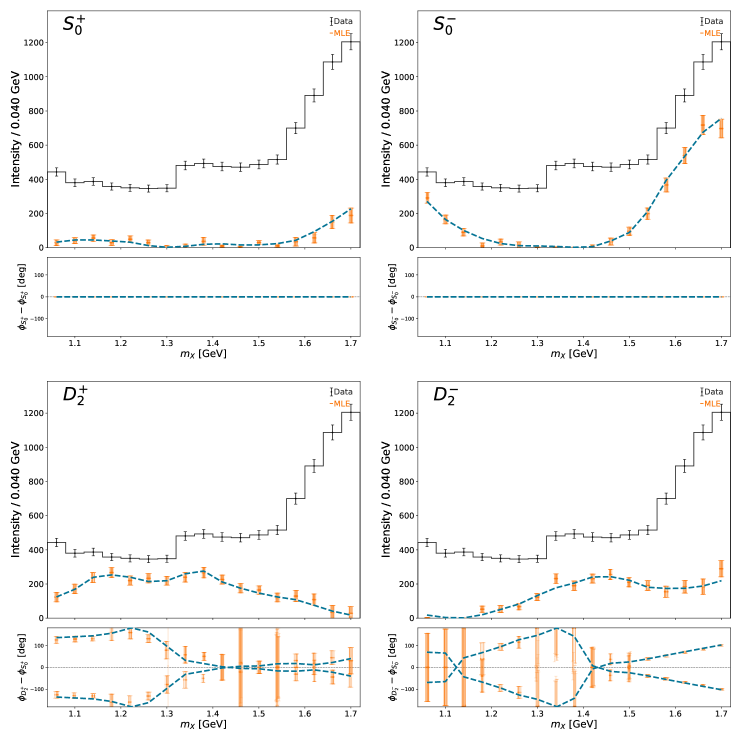

In [18]:
resultManager = ResultManager(main_yaml, silence=True) # Silence all the helpful output for clean documentation
resultManager.attempt_load_all()
plot_overview_across_bins(resultManager, file_type='pdf')
montage_and_gif_select_plots(resultManager, file_type='pdf')
show_pdf("RESULTS/PLOTS/intensity_and_phases/montage_output.pdf")
del resultManager

## Run MCMC fits using NUTS algorithm

MCMC is a set of techniques that draws samples from the posterior distribution. This framework uses Hamiltonian Monte Carlo (HMC) implemented in the No U-Turn Sampler (NUTS) algorithm. For this study, we choose 8 independent chains (each starting off in a different region of parameter space, traverses and draws samples from the posterior). **n_warmup** designates the number of samples to discard as the chains move toward a posterior mode and is used to adapt internal NUTS parameters. **n_samples** is the number of samples to draw for each chain. **n_chains** is drawn for each mass bin independently and the work is pooled across all **n_processes** processes.

The newly created MCMC results is automatically loaded by the **ResultManager** class and the same plotting calls are made

In [ ]:
n_processes = 17
n_chains = 8
n_warmup = 500
n_samples = 1000
stdout, stderr = run_command(f"pa run_mcmc {main_yaml} -np {n_processes} -nc {n_chains} -nw {n_warmup} -ns {n_samples}")

In [ ]:
resultManager = ResultManager(main_yaml, silence=True)
resultManager.attempt_load_all()
plot_overview_across_bins(resultManager, file_type='pdf')
montage_and_gif_select_plots(resultManager, file_type='pdf')
show_pdf("RESULTS/PLOTS/intensity_and_phases/montage_output.pdf")
del resultManager

## Run `iftpwa` fit

Finally we run a IFT analysis with the same prior model used to generate the synthetic data to obtain a posterior estimate. These are shown in the **solid lines**

In [ ]:
stdout, stderr = run_command(f"pa run_ift {main_yaml}")

In [ ]:
resultManager = ResultManager(main_yaml, silence=True)
resultManager.attempt_load_all()
plot_overview_across_bins(resultManager, file_type='pdf')
montage_and_gif_select_plots(resultManager, file_type='pdf')
show_pdf("RESULTS/PLOTS/intensity_and_phases/montage_output.pdf")
del resultManager

In [19]:
os.system(f'rm -rf main.yaml local_beam.conf *.lock')
os.system(f'rm -r RESULTS')

0